In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier

In [2]:
#データインポート
df_ldata = pd.read_csv("../1_data/ks-projects-201801.csv")
display(df_ldata.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
#deadlineとlaunchedの差分計算
df_ldata['deadline'] = pd.to_datetime(df_ldata['deadline'],format='%Y-%m-%d')
df_ldata['launched'] = pd.to_datetime(df_ldata['launched'],format='%Y-%m-%d')

df_ldata['terms'] = (df_ldata['deadline'] - df_ldata['launched']).astype('timedelta64[D]')
#terms = df_prj['terms'].value_counts()
#print(terms)
display(df_ldata.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,terms
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,58.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,59.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,44.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,29.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,55.0


In [4]:
country = df_ldata['country'].value_counts()
print(country)

US      292627
GB       33672
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64


In [5]:
currency = df_ldata['currency'].value_counts()
print(currency)

USD    295365
GBP     34132
EUR     17405
CAD     14962
AUD      7950
SEK      1788
MXN      1752
NZD      1475
DKK      1129
CHF       768
NOK       722
HKD       618
SGD       555
JPY        40
Name: currency, dtype: int64


## 前処理

In [6]:
#説明変数選定

#必要な変数
#category               プロジェクトのカテゴリ
#main_category          プロジェクトのメインカテゴリー
#country                国（Currencyは通貨によるお金の集めやすさが影響する可能性あり）
#usd_goal_real          実際の目標金額（goalは通貨をそろえないと平等でない）
#terms　　　　　　　　　プロジェクト期間

#不要な変数
#ID                     プロジェクトID
#name                   プロジェクト名
#deadline               プロジェクト納期
#launched               プロジェクト開始日
#pledged                確定した金額
#backers                後援者
#usd_pledged_real       実際に獲得した金額
#usd pledged         使った金額
#usd_goal_real          実際の目標金額
#goal                   目標金額
#currency               通貨

#state                  ステータス　⇒不要（目的変数）

In [7]:
#不要な説明変数をまずは除去する
df_ldata_col=['ID','name','deadline','launched','pledged','backers','currency','usd_pledged_real','usd pledged','goal']
df_prj = df_ldata.drop(df_ldata_col,axis=1)
display(df_prj.head())

,category,main_category,state,country,usd_goal_real,terms
0,Poetry,Publishing,failed,GB,1533.95,58.0
1,Narrative Film,Film & Video,failed,US,30000.00,59.0
2,Narrative Film,Film & Video,failed,US,45000.00,44.0
3,Music,Music,failed,US,5000.00,29.0
4,Film & Video,Film & Video,canceled,US,19500.00,55.0


In [8]:
#stateを数値化

#failed        197719　⇒0
#successful    133956　⇒1
#canceled       38779　⇒一旦除外
#undefined       3562　⇒除外
#live            2799　⇒除外
#suspended       1846　⇒一旦除外

df_prj['state'] = df_prj['state'].map({'failed': 0, 'successful': 1})
df_prj.head()

,category,main_category,state,country,usd_goal_real,terms
0,Poetry,Publishing,0.0,GB,1533.95,58.0
1,Narrative Film,Film & Video,0.0,US,30000.00,59.0
2,Narrative Film,Film & Video,0.0,US,45000.00,44.0
3,Music,Music,0.0,US,5000.00,29.0
4,Film & Video,Film & Video,NaN,US,19500.00,55.0


In [9]:
#行数確認
df_prj.shape

(378661, 6)

In [10]:
#欠損値確認
df_prj.isnull().sum()

category             0
main_category        0
state            46986
country              0
usd_goal_real        0
terms                0
dtype: int64

In [11]:
#stateの欠損値の行を除く
df_prj = df_prj.dropna(subset=['state'])

In [12]:
#欠損値確認
df_prj.isnull().sum()

category         0
main_category    0
state            0
country          0
usd_goal_real    0
terms            0
dtype: int64

In [13]:
df_prj.shape
#3万行以上あるので問題ない

(331675, 6)

In [14]:
state = df_prj['state'].value_counts()
print(state)

0.0    197719
1.0    133956
Name: state, dtype: int64


In [15]:
df_prj.head()

,category,main_category,state,country,usd_goal_real,terms
0,Poetry,Publishing,0.0,GB,1533.95,58.0
1,Narrative Film,Film & Video,0.0,US,30000.00,59.0
2,Narrative Film,Film & Video,0.0,US,45000.00,44.0
3,Music,Music,0.0,US,5000.00,29.0
5,Restaurants,Food,1.0,US,50000.00,34.0


In [16]:
cat = df_prj['category'].value_counts()
print(cat)

Product Design       18680
Documentary          14523
Music                12633
Tabletop Games       11744
Shorts               11394
Food                 10416
Video Games           9328
Film & Video          8624
Fiction               8108
Fashion               7529
Art                   7486
Nonfiction            7414
Theater               6684
Rock                  6246
Children's Books      6198
Apparel               6166
Technology            5726
Indie Rock            5329
Apps                  5287
Photography           5246
Webseries             5148
Publishing            5052
Narrative Film        4618
Comics                4581
Web                   4309
Country & Folk        4213
Crafts                4152
Design                3547
Hip-Hop               3459
Hardware              3115
                     ...  
Blues                  234
Animals                229
Couture                227
Fabrication Tools      215
Makerspaces            208
Movie Theaters         201
P

In [17]:
maincat = df_prj['main_category'].value_counts()
print(maincat)

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64


In [18]:
#categoryは種類が多すぎるので一旦省く
df_prj_col=['category']
df_prj = df_prj.drop(df_prj_col,axis=1)
display(df_prj.head())

,main_category,state,country,usd_goal_real,terms
0,Publishing,0.0,GB,1533.95,58.0
1,Film & Video,0.0,US,30000.00,59.0
2,Film & Video,0.0,US,45000.00,44.0
3,Music,0.0,US,5000.00,29.0
5,Food,1.0,US,50000.00,34.0


In [19]:
#カテゴリーを数値化
df_prj = pd.get_dummies(df_prj,columns=['main_category','country'])
df_prj.head()

,state,usd_goal_real,terms,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0.0,1533.95,58.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,30000.00,59.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0.0,45000.00,44.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0.0,5000.00,29.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1.0,50000.00,34.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
# 相関係数確認
df_prj.corr()

,state,usd_goal_real,terms,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
state,1.000000,-0.023735,-0.116437,0.026554,0.066964,-0.042224,0.053270,0.007077,-0.062116,0.012959,...,-0.001689,-0.001885,-0.016415,0.004931,-0.025805,-0.010726,-0.006610,-0.009172,-0.000891,0.056250
usd_goal_real,-0.023735,1.000000,0.021607,-0.000542,-0.003368,-0.004421,-0.003122,-0.000849,-0.004456,0.014136,...,-0.000215,-0.000090,-0.001605,-0.000473,0.002215,0.000104,-0.000977,-0.000167,-0.000889,-0.003756
terms,-0.116437,0.021607,1.000000,-0.036935,-0.001492,-0.030644,-0.009370,0.004161,-0.026564,0.037582,...,-0.003417,0.002037,0.013080,-0.003276,-0.004459,0.002682,-0.012681,-0.003591,-0.005289,0.035199
main_category_Art,0.026554,-0.000542,-0.036935,1.000000,-0.050714,-0.044973,-0.030206,-0.083293,-0.072884,-0.131198,...,-0.001055,-0.000350,0.005016,-0.007286,-0.003108,-0.003774,-0.003192,-0.001955,-0.004610,0.006736
main_category_Comics,0.066964,-0.003368,-0.001492,-0.050714,1.000000,-0.027222,-0.018283,-0.050416,-0.044116,-0.079412,...,-0.001459,-0.000944,-0.003821,-0.004410,-0.011860,-0.000565,-0.006578,-0.005256,-0.003128,0.016279
main_category_Crafts,-0.042224,-0.004421,-0.030644,-0.044973,-0.027222,1.000000,-0.016214,-0.044709,-0.039122,-0.070423,...,-0.001294,-0.002037,0.007249,-0.003911,-0.001832,-0.000341,0.001597,-0.000759,0.007148,-0.009607
main_category_Dance,0.053270,-0.003122,-0.009370,-0.030206,-0.018283,-0.016214,1.000000,-0.030029,-0.026276,-0.047300,...,-0.000869,-0.001368,0.002603,-0.002627,-0.004116,-0.001584,-0.002703,-0.004451,-0.003074,0.018970
main_category_Design,0.007077,-0.000849,0.004161,-0.083293,-0.050416,-0.044709,-0.030029,1.000000,-0.072457,-0.130428,...,0.003053,0.001420,-0.005212,-0.006792,0.014774,0.000676,0.006158,0.004653,0.025555,-0.041687
main_category_Fashion,-0.062116,-0.004456,-0.026564,-0.072884,-0.044116,-0.039122,-0.026276,-0.072457,1.000000,-0.114129,...,0.008607,-0.000387,-0.005503,-0.005832,0.012029,-0.000213,0.002890,0.000952,0.022018,-0.032608
main_category_Film & Video,0.012959,0.014136,0.037582,-0.131198,-0.079412,-0.070423,-0.047300,-0.130428,-0.114129,1.000000,...,-0.003775,-0.004719,0.002405,-0.004077,-0.022362,-0.007125,-0.005331,-0.008838,-0.013528,0.046882


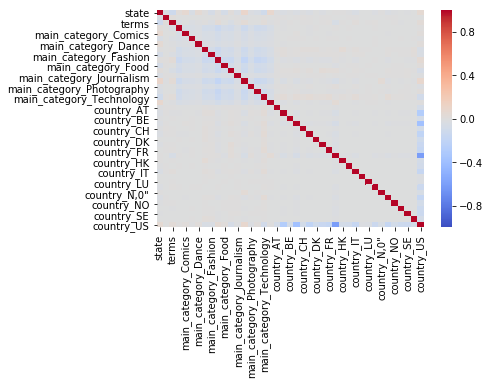

In [21]:
# 相関係数をヒートマップにして可視化
#sns.heatmap(df_ctg.corr())

sns.heatmap(df_prj.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

## 予測

In [22]:
#予測
y = df_prj["state"].values
X = df_prj.drop("state",axis=1).values

print(X)

#ロジスティック回帰
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}".format(w0, w1, w2, w3, w4, w5))

[[1.53395e+03 5.80000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [3.00000e+04 5.90000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  1.00000e+00]
 [4.50000e+04 4.40000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  1.00000e+00]
 ...
 [1.50000e+04 4.50000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  1.00000e+00]
 [1.50000e+04 3.00000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  1.00000e+00]
 [2.00000e+03 2.70000e+01 1.00000e+00 ... 0.00000e+00 0.00000e+00
  1.00000e+00]]
w0 = 8338.866, w1 = -642.503, w2 = 207329.234, w3 = 610.126, w4 = 593.135, w5 = -216.750


In [23]:
#評価
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ラベルを予測
y_pred = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_pred)))

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -15.414
正答率（Accuracy） = 55.374%
適合率（Precision） = 71.268%
再現率（Recall） = 42.120%
F1値（F1-score） = 52.948%


In [33]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_pred), 
                        index=['成功', '失敗'], 
                        columns=['成功', '失敗'])
conf_mat

,成功,失敗
成功,83280,114439
失敗,33574,100382


In [34]:
#汎化誤差評価
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数

In [35]:
#ホールドアウト法でテストデータを分ける
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

# 件数確認
print('X_train:',len(X_train))
print('y_train:',len(y_train))
print('X_test:',len(X_test))
print('y_test:',len(y_test))

X_train: 265340
y_train: 265340
X_test: 66335
y_test: 66335


In [36]:
# データ標準化
from sklearn.preprocessing import StandardScaler

#stdsc = StandardScaler()

#X_train_kf = stdsc.fit_transform(X_train)
#X_test_kf = stdsc.fit_transform(X_test)

# 件数確認
#print('X_train:',len(X_train))
#print('y_train:',len(y_train))
#print('X_test:',len(X_test))
#print('y_test:',len(y_test))
#print('X_train_kf:',len(X_train_kf))
#print('X_test_kf:',len(X_test_kf))

In [28]:
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

#交差検証法で汎化誤差計算
n_split = 5 # グループ数を設定（今回は5分割）
cross_valid_log_loss = 0
cross_valid_accuracy_score = 0
cross_valid_precision_score = 0
cross_valid_recall_score = 0
cross_valid_f1_score = 0
split_num = 1
stdsc = StandardScaler()

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X_train, y_train):
    X_train_kf, y_train_kf = X_train[train_idx], y_train[train_idx] #学習用データ
    X_test_kf, y_test_kf = X_train[test_idx], y_train[test_idx]     #テスト用データ
    
    print(len(X_train_kf),len(y_train_kf),len(X_test_kf),len(y_test_kf))

    # データを標準化
    X_train_kf = stdsc.fit_transform(X_train_kf)
    X_test_kf = stdsc.fit_transform(X_test_kf)
    
    print(len(X_train_kf),len(y_train_kf),len(X_test_kf),len(y_test_kf))
    
    # 学習用データを使ってロジスティック回帰モデルを学習
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf.fit(X_train_kf, y_train_kf)

    # テストデータに対する予測を実行
    y_pred_test = clf.predict(X_test_kf)
    
    print(len(X_test_kf),len(y_test_kf),len(y_pred_test))
    
    # 対数尤度を表示
    ls = log_loss(y_test_kf, y_pred_test)
    print('対数尤度 = {:.3f}'.format(- ls))
    
    # 正答率を表示
    acs = accuracy_score(y_test_kf, y_pred_test)
    print('正答率 = {:.3f}%'.format(100 * acs))
    
    # Precision, Recall, F1-scoreを計算
#    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_kf, y_pred_test)

    # Precision, Recall, F1-scoreを表示
#    print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
#    print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
#    print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
    
    # テストデータに対するMAEを計算
    print("Fold %s"%split_num)
    print()
    
    cross_valid_log_loss += ls #後で平均を取るためにMAEを加算
    cross_valid_accuracy_score += acs #後で平均を取るためにMAEを加算
    cross_valid_precision_score += precision #後で平均を取るためにMAEを加算
    cross_valid_recall_score += recall #後で平均を取るためにMAEを加算
    cross_valid_f1_score += f1_score #後で平均を取るためにMAEを加算
    split_num += 1
    
# MAEの平均値を最終的な汎化誤差値とする
print("対数尤度（平均） = %s"%round(cross_valid_log_loss / n_split, 3))
print("正答率（平均） = %s"%round(cross_valid_accuracy_score / n_split, 3))
#print("適合率（平均） = %s"%round(cross_valid_precision_score / n_split, 3))
#print("再現率（平均） = %s"%round(cross_valid_recall_score / n_split, 3))
#print("F1値（平均） = %s"%round(cross_valid_f1_score / n_split, 3))

212272 212272 53068 53068
212272 212272 53068 53068
53068 53068 53068
対数尤度 = -12.533
正答率 = 63.714%
Fold 1

212272 212272 53068 53068
212272 212272 53068 53068
53068 53068 53068
対数尤度 = -12.820
正答率 = 62.883%
Fold 2

212272 212272 53068 53068
212272 212272 53068 53068
53068 53068 53068
対数尤度 = -12.339
正答率 = 64.276%
Fold 3

212272 212272 53068 53068
212272 212272 53068 53068
53068 53068 53068
対数尤度 = -12.445
正答率 = 63.967%
Fold 4

212272 212272 53068 53068
212272 212272 53068 53068
53068 53068 53068
対数尤度 = -12.295
正答率 = 64.402%
Fold 5

対数尤度（平均） = 12.486
正答率（平均） = 0.638


In [37]:
#交差検証
#from sklearn.model_selection import cross_val_score

# 交差検定
#scores_accuracy = cross_val_score(clf, X_train_kf, y_train, cv=5, scoring='accuracy')
#scores_recall = cross_val_score(clf, X_train_kf, y_train, cv=5, scoring='recall')
#scores_precision = cross_val_score(clf, X_train_kf, y_train, cv=5, scoring='precision')
#scores_neg_log_lossl = cross_val_score(clf, X_train_kf, y_train, cv=5, scoring='neg_log_loss')
#scores_auc = cross_val_score(clf, X_train_kf, y_train, cv=5, scoring='roc_auc')

# 各分割におけるスコア
#print('Cross-Validation scores(accuracy): {}'.format(scores_accuracy))
#print('Cross-Validation scores(recall): {}'.format(scores_recall))
#print('Cross-Validation scores(precision): {}'.format(scores_precision))
#print('Cross-Validation scores(log_loss): {}'.format(scores_neg_log_lossl))
#print('Cross-Validation scores(AUC): {}'.format(scores_auc))
#print('')
#print('Average score(accuracy): {}'.format(np.mean(100*scores_accuracy)))
#print('Average score(recall): {}'.format(np.mean(100*scores_recall)))
#print('Average score(precision): {}'.format(np.mean(100*scores_precision)))
#print('Average score(log_loss): {}'.format(np.mean(scores_neg_log_lossl)))
#print('Average score(AUC): {}'.format(np.mean(100*scores_auc)))

## ステップワイズ法

In [38]:
y = df_prj["state"].values
X = df_prj[df_prj.columns[df_prj.columns != 'state']]
print(y)

[0. 0. 0. ... 0. 0. 0.]


In [39]:
#ステップワイズ法で変数の必要・不必要を判別
from sklearn.feature_selection import RFECV

# estimatorにモデルをセット
estimator = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=10, scoring='accuracy')

In [32]:
#特徴選択　⇒処理が終わらない
rfecv.fit(X, y)

KeyboardInterrupt: 

In [40]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

AttributeError: 'RFECV' object has no attribute 'ranking_'

## 埋め込み法

In [41]:
#埋め込み法で変数の必要・不必要を判別

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# 係数のしきい値はthre
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下sholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [42]:
# fitで特徴選択を実行
sfm.fit(X, y)

C:\Users\sst777080\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [43]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特特徴が使用する徴
sfm.get_support()

array([False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [44]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
X.columns[removed_idx]

Index(['usd_goal_real', 'main_category_Film & Video'], dtype='object')

In [45]:
#'usd_goal_real'と'main_category_Film & Video'は消してもいいようだが、一旦ランダムフォレストを先にやる

## ランダムフォレスト

In [46]:
y = df_prj["state"].values
X = df_prj[df_prj.columns[df_prj.columns != 'state']]

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
clf = RandomForestClassifier(n_estimators=10, max_depth=10, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(X, y)
print("score=", clf.score(X, y))

score= 0.6553493630813296


In [50]:
importance = pd.DataFrame({ '変数' :X.columns, '重要度' :clf.feature_importances_})
importance

,変数,重要度
0,usd_goal_real,0.479025
1,terms,0.174362
2,main_category_Art,0.002255
3,main_category_Comics,0.019318
4,main_category_Crafts,0.008720
5,main_category_Dance,0.012126
6,main_category_Design,0.006497
7,main_category_Fashion,0.026709
8,main_category_Film & Video,0.004754
9,main_category_Food,0.022059


[4.79025410e-01 1.74362160e-01 2.25502242e-03 1.93176929e-02
 8.72023461e-03 1.21257995e-02 6.49718652e-03 2.67090055e-02
 4.75421956e-03 2.20587088e-02 1.23099468e-02 7.87590255e-03
 6.82293590e-02 3.39598070e-03 1.40911589e-02 5.14926872e-02
 5.28015856e-02 1.66578580e-04 2.03029489e-03 2.37347299e-04
 1.27653380e-03 3.82074562e-04 7.95657762e-04 2.41878588e-04
 6.42595894e-04 7.35863424e-04 1.78721250e-03 5.98204951e-04
 2.28062850e-04 3.63512587e-03 1.08247371e-05 2.59116173e-05
 1.38576771e-03 1.93534285e-04 1.20857766e-03 3.08789354e-04
 1.85786155e-04 4.20817109e-04 2.84847703e-04 1.71956521e-02]


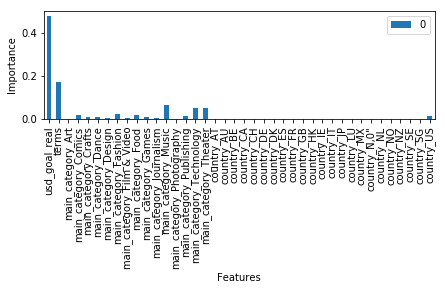

In [51]:
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=X.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [52]:
#埋め込み法でも不要と判断された'main_category_Film & Video'より重要度が低い変数は除く
#CuntoryはUS以外重要度が低いため、変数から外してみる。
df_prj_col2=['main_category_Art','main_category_Film & Video','main_category_Journalism','country_AT','country_AU','country_BE','country_BE','country_CA','country_CH','country_DE','country_DK','country_ES','country_FR','country_HK','country_IE','country_JP','country_LU','country_MX','country_N,0"','country_NL','country_NO','country_NZ','country_SE','country_SG']
df_prj2 = df_prj.drop(df_prj_col2,axis=1)

In [53]:
y = df_prj2["state"].values
X = df_prj2[df_prj2.columns[df_prj2.columns != 'state']]

In [54]:
clf2 = RandomForestClassifier(n_estimators=10, max_depth=10, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf2.fit(X, y)
print("score=", clf2.score(X, y))

score= 0.6555875480515565


In [55]:
importance = pd.DataFrame({ '変数' :X.columns, '重要度' :clf2.feature_importances_})
importance

,変数,重要度
0,usd_goal_real,0.401855
1,terms,0.270095
2,main_category_Comics,0.024572
3,main_category_Crafts,0.006327
4,main_category_Dance,0.015592
5,main_category_Design,0.004622
6,main_category_Fashion,0.026993
7,main_category_Food,0.025713
8,main_category_Games,0.008311
9,main_category_Music,0.071225


In [56]:
#ランダムフォレストの深さを変える
clf2 = RandomForestClassifier(n_estimators=10, max_depth=30, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf2.fit(X, y)
print("score=", clf2.score(X, y))

score= 0.7326660134167483


In [57]:
importance = pd.DataFrame({ '変数' :X.columns, '重要度' :clf2.feature_importances_})
importance

,変数,重要度
0,usd_goal_real,0.605523
1,terms,0.233683
2,main_category_Comics,0.011319
3,main_category_Crafts,0.008868
4,main_category_Dance,0.006935
5,main_category_Design,0.005579
6,main_category_Fashion,0.014321
7,main_category_Food,0.011849
8,main_category_Games,0.006039
9,main_category_Music,0.022036


[0.60552309 0.23368282 0.01131873 0.00886838 0.00693459 0.00557915
 0.01432081 0.01184852 0.00603872 0.02203646 0.00476229 0.00916705
 0.02229702 0.01737119 0.00609572 0.00290973 0.01124572]


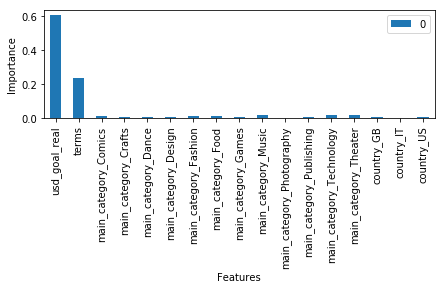

In [58]:
print(clf2.feature_importances_)
pd.DataFrame(clf2.feature_importances_, index=X.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

## 再度予測

In [59]:
#予測
y = df_prj2["state"].values
X = df_prj2.drop("state",axis=1).values

print(X)

#ロジスティック回帰
clf3 = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf3.fit(X, y)

# 重みを取得して表示
w0 = clf3.intercept_[0]
w1 = clf3.coef_[0, 0]
w2 = clf3.coef_[0, 1]
w3 = clf3.coef_[0, 2]
w4 = clf3.coef_[0, 3]
w5 = clf3.coef_[0, 4]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}".format(w0, w1, w2, w3, w4, w5))

[[1.53395e+03 5.80000e+01 0.00000e+00 ... 1.00000e+00 0.00000e+00
  0.00000e+00]
 [3.00000e+04 5.90000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  1.00000e+00]
 [4.50000e+04 4.40000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  1.00000e+00]
 ...
 [1.50000e+04 4.50000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  1.00000e+00]
 [1.50000e+04 3.00000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  1.00000e+00]
 [2.00000e+03 2.70000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  1.00000e+00]]
w0 = 8505.432, w1 = -662.325, w2 = 212898.825, w3 = 600.193, w4 = -211.271, w5 = 250.678


In [60]:
#評価
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ラベルを予測
y_pred = clf3.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_pred)))

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -15.420
正答率（Accuracy） = 55.357%
適合率（Precision） = 71.154%
再現率（Recall） = 42.231%
F1値（F1-score） = 53.004%


In [61]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_pred), 
                        index=['成功', '失敗'], 
                        columns=['成功', '失敗'])
conf_mat

,成功,失敗
成功,83499,114220
失敗,33851,100105


In [62]:
#ホールドアウト法でテストデータを分ける
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

# 件数確認
print('X_train:',len(X_train))
print('y_train:',len(y_train))
print('X_test:',len(X_test))
print('y_test:',len(y_test))

X_train: 265340
y_train: 265340
X_test: 66335
y_test: 66335


In [63]:
#交差検証法で汎化誤差計算
n_split = 5 # グループ数を設定（今回は5分割）
cross_valid_log_loss = 0
cross_valid_accuracy_score = 0
cross_valid_precision_score = 0
cross_valid_recall_score = 0
cross_valid_f1_score = 0
split_num = 1
stdsc = StandardScaler()

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X_train, y_train):
    X_train_kf, y_train_kf = X_train[train_idx], y_train[train_idx] #学習用データ
    X_test_kf, y_test_kf = X_train[test_idx], y_train[test_idx]     #テスト用データ
    
    print(len(X_train_kf),len(y_train_kf),len(X_test_kf),len(y_test_kf))

    # データを標準化
    X_train_kf = stdsc.fit_transform(X_train_kf)
    X_test_kf = stdsc.fit_transform(X_test_kf)
    
    print(len(X_train_kf),len(y_train_kf),len(X_test_kf),len(y_test_kf))
    
    # 学習用データを使ってロジスティック回帰モデルを学習
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf.fit(X_train_kf, y_train_kf)

    # テストデータに対する予測を実行
    y_pred_test = clf.predict(X_test_kf)
    
    print(len(X_test_kf),len(y_test_kf),len(y_pred_test))
    
    # 対数尤度を表示
    ls = log_loss(y_test_kf, y_pred_test)
    print('対数尤度 = {:.3f}'.format(- ls))
    
    # 正答率を表示
    acs = accuracy_score(y_test_kf, y_pred_test)
    print('正答率 = {:.3f}%'.format(100 * acs))
    
    # Precision, Recall, F1-scoreを計算
#    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_kf, y_pred_test)

    # Precision, Recall, F1-scoreを表示
#    print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
#    print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
#    print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
    
    # テストデータに対するMAEを計算
    print("Fold %s"%split_num)
    print()
    
    cross_valid_log_loss += ls #後で平均を取るためにMAEを加算
    cross_valid_accuracy_score += acs #後で平均を取るためにMAEを加算
    cross_valid_precision_score += precision #後で平均を取るためにMAEを加算
    cross_valid_recall_score += recall #後で平均を取るためにMAEを加算
    cross_valid_f1_score += f1_score #後で平均を取るためにMAEを加算
    split_num += 1
    
# MAEの平均値を最終的な汎化誤差値とする
print("対数尤度（平均） = %s"%round(cross_valid_log_loss / n_split, 3))
print("正答率（平均） = %s"%round(cross_valid_accuracy_score / n_split, 3))
#print("適合率（平均） = %s"%round(cross_valid_precision_score / n_split, 3))
#print("再現率（平均） = %s"%round(cross_valid_recall_score / n_split, 3))
#print("F1値（平均） = %s"%round(cross_valid_f1_score / n_split, 3))

212272 212272 53068 53068
212272 212272 53068 53068
53068 53068 53068
対数尤度 = -12.484
正答率 = 63.854%
Fold 1

212272 212272 53068 53068
212272 212272 53068 53068
53068 53068 53068
対数尤度 = -12.649
正答率 = 63.377%
Fold 2

212272 212272 53068 53068
212272 212272 53068 53068
53068 53068 53068
対数尤度 = -12.252
正答率 = 64.527%
Fold 3

212272 212272 53068 53068
212272 212272 53068 53068
53068 53068 53068
対数尤度 = -12.452
正答率 = 63.948%
Fold 4

212272 212272 53068 53068
212272 212272 53068 53068
53068 53068 53068
対数尤度 = -12.654
正答率 = 63.364%
Fold 5

対数尤度（平均） = 12.498
正答率（平均） = 0.638


## ニューラルネットワーク

In [ ]:
from keras.utils.np_utils import to_categorical 
y_train = to_categorical(y_train) 
X_train_kf = to_categorical(X_train_kf) 
#X_test = to_categorical(X_test) 
#y_test = to_categorical(y_test) 

In [66]:
from tensorflow import keras  
import tensorflow as tf
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(6, activation='relu', input_dim=5))
model.add(Dense(5, activation='relu', input_dim=6))
model.add(Dense(3, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

# WARNINGが出るが気にしなくて良い

W0809 11:22:22.262411 13232 deprecation.py:506] From C:\Users\sst777080\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [67]:
# 計算の実行
fit = model.fit(X_train_kf, y_train,
          epochs=50,
          batch_size=20,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

ValueError: Error when checking input: expected dense_input to have 2 dimensions, but got array with shape (212272, 17, 112)